<html> <h1 style="font-style:bold; color:blue;"> Neural Computing and Deep Learning </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-7 </h1> </html>


<html> <h2 style="font-style:italic; color:blue;"> Transfer Learning </h2> </html>



<html> <h3 style="font-style:italic; color:blue;"> CIFAR10 Transfer Learning based Classifier </h3> </html>


<html> <h3 style="font-style:italic; color:blue;"> VGG16 and VGG19</h3> </html>


##### This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilising a pretrained Deep-CNNs.


In [1]:
# For Google Colab only!

!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

Model: 		 Unknown
IRQ:   		 11
GPU UUID: 	 GPU-e3e88b22-e668-e338-4d5f-59ff03d61026
Video BIOS: 	 90.04.a7.00.01
Bus Type: 	 PCI
DMA Size: 	 47 bits
DMA Mask: 	 0x7fffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
GPU Excluded:	 No


In [2]:
!pip install np_utils  # - need to run only one time

In [3]:
pip install scipy==1.11.4    # - need to run only one time

In [4]:
# import

import scipy as sp
import numpy as np
import pandas as pd

from numpy.random import rand
pd.options.display.max_colwidth = 600

In [5]:
# Scikit Imports

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split



In [6]:
# Use code in this cell for Google Colab only

# Run the cell twice and upload two filea (see the next 2 cells)
# cnn_utils.py                 and
# model_evaluation_utils.py

from google.colab import files
uploaded = files.upload()

In [7]:
ls

cnn_utils.py  model_evaluation_utils.py  __pycache__/  sample_data/


As a result, the previous cell should show 2 files uploaded to Colab.

In [8]:
# Downloading the personal libraries

# Source the library here:
# https://github.com/JudasDie/deeplearning.ai/blob/master/Convolutional%20Neural%20Networks/week1/cnn_utils.py

import cnn_utils as utils

In [9]:
from scipy import interp

In [10]:
# Downloading the personal libraries

# Source the library here:
# https://github.com/dipanjanS/hands-on-transfer-learning-with-python/blob/master/notebooks/Ch06%20-%20Image%20Recognition%20and%20Classification/model_evaluation_utils.py


from model_evaluation_utils import get_metrics

In [11]:
# Matplot Imports

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

In [12]:
# pandas display data frames as tables

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [13]:
import tensorflow as tf
from tensorflow import keras

from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10

from keras import Model

from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [14]:
import np_utils

from keras.utils import to_categorical

### Load and manipulate the DataSet

In [15]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [16]:
# Download the dataset

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()


In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [18]:
# Split training dataset in train and validation sets:

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [19]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(42500, 1)
(7500, 1)
(10000, 1)


In [20]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.7Gi       8.2Gi       6.0Mi       2.8Gi        10Gi
Swap:             0B          0B          0B


The previous cell checks for free memory

In [21]:
# Transform target variable/labels into one hot encoded form

Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val   = to_categorical(y_val, NUM_CLASSES)
Y_test  = to_categorical(y_test, NUM_CLASSES)

In [22]:
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(42500, 10)
(7500, 10)
(10000, 10)


### Preprocessing

In [23]:
# Since we are about to use VGG16 and VGG19as a feature extractor, the minimum size of an image its take is 48x48.
# We utilize ```scipy`` to resize images to required dimensions


In [24]:
from skimage import transform

X_train = np.array([transform.resize(x,
                                     (48, 48)) for x in X_train])
X_val   = np.array([transform.resize(x,
                                     (48, 48)) for x in X_val])
X_test  = np.array([transform.resize(x,
                                     (48, 48)) for x in X_test])


In [25]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(42500, 48, 48, 3)
(7500, 48, 48, 3)
(10000, 48, 48, 3)


In [26]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       5.7Gi       4.1Gi       6.0Mi       2.8Gi       6.6Gi
Swap:             0B          0B          0B


# Create VGG19 Model

- Load VGG16 without the top classification layer
- Create a custom classifier
- Stack both models on top of each other


In [27]:
base_model = vgg.VGG16(weights='imagenet',
                       include_top=False,
                        input_shape=(48, 48, 3)
                      )

In [28]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Extract the last layers from third block of vgg16 model

last = base_model.get_layer('block3_pool').output


In [30]:
# Add classification layers on top of it

x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,870,666 (7.14 MB)

 Trainable params: 1,870,154 (7.13 MB)

 Non-trainable params: 512 (2.00 KB)

In [32]:
# Since our objective is to only train the custom classifier,
# we freeze the layers of VGG16

for layer in base_model.layers:
     layer.trainable = False

In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,140,000 (8.16 MB)

 Trainable params: 134,666 (526.04 KB)

 Non-trainable params: 1,736,000 (6.62 MB)

 Optimizer params: 269,334 (1.03 MB)

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

### Data Augmentation


To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using keras  utilities


In [41]:
# create data augmentation configuration

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [42]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [43]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
                                horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

### Train the Model

In [44]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.3846 - loss: 1.7261 - val_accuracy: 0.5019 - val_loss: 1.4242
Epoch 2/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 1.4012 - val_accuracy: 0.5024 - val_loss: 1.4238
Epoch 3/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.4636 - loss: 1.5041 - val_accuracy: 0.5389 - val_loss: 1.3127
Epoch 4/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4688 - loss: 1.6552 - val_accuracy: 0.5386 - val_loss: 1.3121
Epoch 5/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5068 - loss: 1.3988 - val_accuracy: 0.5586 - val_loss: 1.2461
Epoch 6/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 1.4136 - val_accuracy: 0.5576 - val_loss: 1.2467
Epoch 7/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5272 - loss: 1.3356 - val_accuracy: 0.5737 - val_loss: 1.2004
Epoch 8/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6562 - loss: 1.0

### Analyse Model Performance

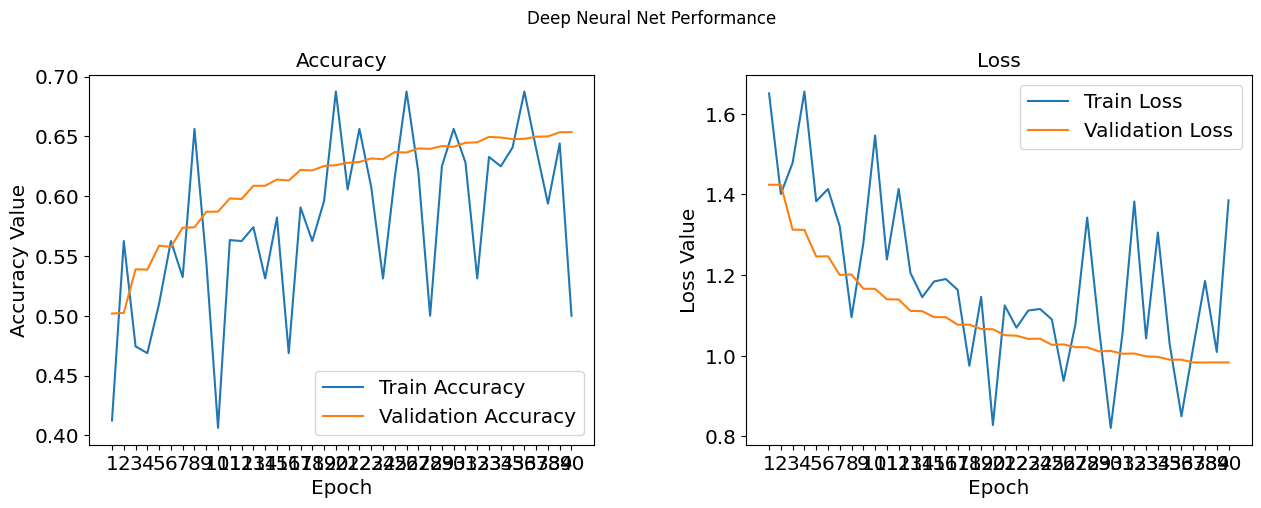

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [46]:
predictions = model.predict(X_test/255.)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [47]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [48]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.655
Precision: 0.6551
Recall: 0.655
F1 Score: 0.654


In [49]:
from sklearn.metrics import classification_report

In [50]:
error_metrics_report = classification_report(y_test, predictions)
print(error_metrics_report)

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1000
           1       0.77      0.72      0.75      1000
           2       0.56      0.54      0.55      1000
           3       0.48      0.45      0.47      1000
           4       0.59      0.58      0.58      1000
           5       0.56      0.59      0.57      1000
           6       0.68      0.78      0.73      1000
           7       0.73      0.63      0.68      1000
           8       0.80      0.79      0.79      1000
           9       0.71      0.74      0.72      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [52]:
PretrainedModels = ['VGG-16', 'VGG_19']

In [53]:
# Create lists for printing final results

ErrorMetrics = []
Accuracy = []
Precision = []
Recall = []
F1_Score = []

In [55]:
Accuracy.append(accuracy_score(y_test, predictions))
Precision.append(precision_score(y_test, predictions, average = 'macro'))
Recall.append(recall_score(y_test, predictions, average = 'macro'))
F1_Score.append(f1_score(y_test, predictions, average = 'macro'))

print(Accuracy, '\n', Precision, '\n', Recall, '\n', F1_Score)

[0.655] 
 [0.6551154152560221] 
 [0.655] 
 [0.6539501197331854]


### Visualise Predictions

In [56]:
#label_dict = {0:'airplane',
#             1:'automobile',
#             2:'bird',
#             3:'cat',
#             4:'deer',
#             5:'dog',
#             6:'frog',
#             7:'horse',
#             8:'ship',
#             9:'truck'}

classes=['aircraft', 'car', 'bird', 'cat', 'deer',
 'dog', 'frog', 'hours', 'ship', 'truck']

In [57]:
# Graph this to look at the full set of 10 class predictions.


def plot_image(i,predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(label_dict[predicted_label],
                                    100 * np.max(predictions_array),
                                    label_dict[true_label]),
                                    color=color)

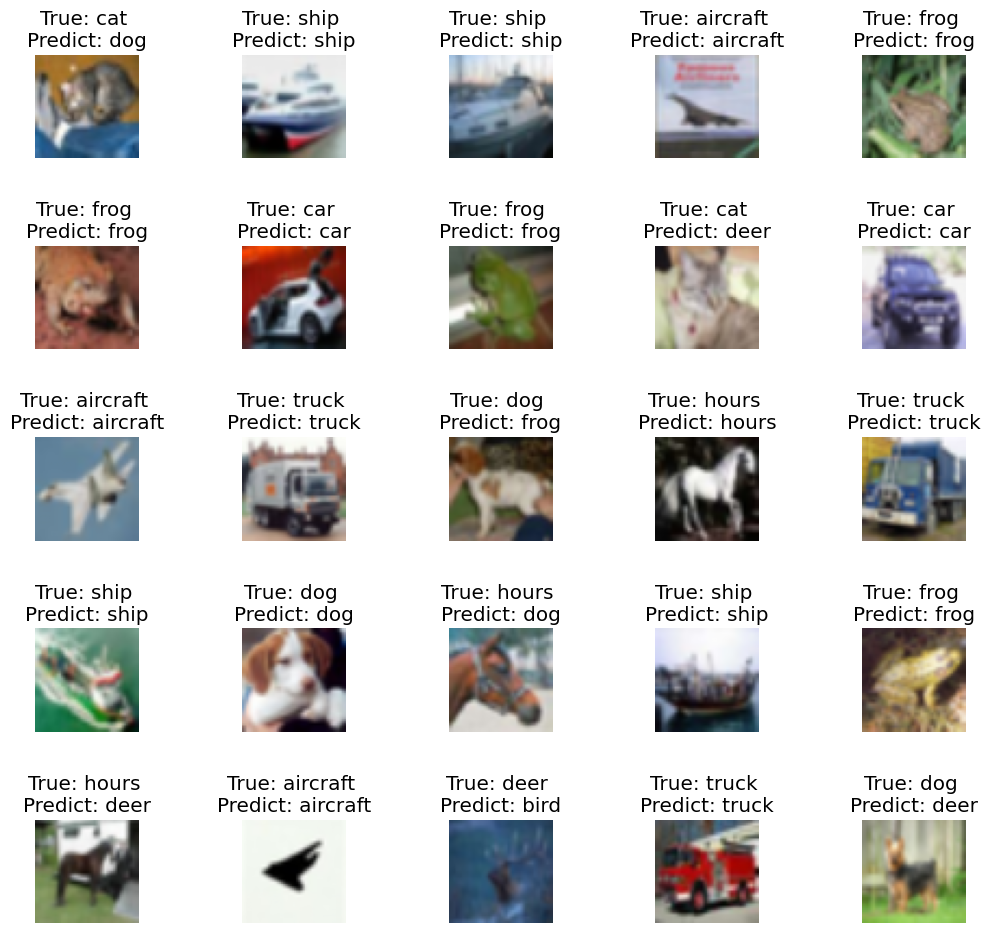

In [58]:
# Demonstration of the classifier prediction results

R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (classes[np.argmax(Y_test[i])],
                                                  classes[predictions[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


# Create VGG19 Model

- Load VGG19 without the top classification layer
- Create a custom classifier
- Stack both models on top of each other


In [59]:
base_model_2 = keras.applications.VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3)
                      )

In [60]:
base_model_2.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Extract the last layers from the fifth block of vgg19 model

last = base_model_2.get_layer('block5_pool').output


In [62]:
# Add classification layers on top of it

x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model_2 = Model(base_model_2.input, pred)

In [63]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,226,122 (77.16 MB)

 Trainable params: 20,225,098 (77.15 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [64]:
# Since our objective is to only train the custom classifier,
# we freeze the layers of VGG19

for layer in base_model_2.layers:
     layer.trainable = False

In [65]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,226,122 (77.16 MB)

 Trainable params: 200,714 (784.04 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

In [66]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

### Train the Model_2

In [67]:
history_2 = model_2.fit(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.2077 - loss: 2.1801 - val_accuracy: 0.3393 - val_loss: 1.8546
Epoch 2/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2812 - loss: 1.7541 - val_accuracy: 0.3393 - val_loss: 1.8542
Epoch 3/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.3060 - loss: 1.8732 - val_accuracy: 0.3763 - val_loss: 1.7453
Epoch 4/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3125 - loss: 1.8797 - val_accuracy: 0.3777 - val_loss: 1.7456
Epoch 5/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - accuracy: 0.3418 - loss: 1.7970 - val_accuracy: 0.3925 - val_loss: 1.6933
Epoch 6/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3125 - loss: 2.0762 - val_accuracy: 0.3918 - val_loss: 1.6939
Epoch 7/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3616 - loss: 1.7457 - val_accuracy: 0.4091 - val_loss: 1.6555
Epoch 8/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3750 - loss: 1

### Analyse Model Performance

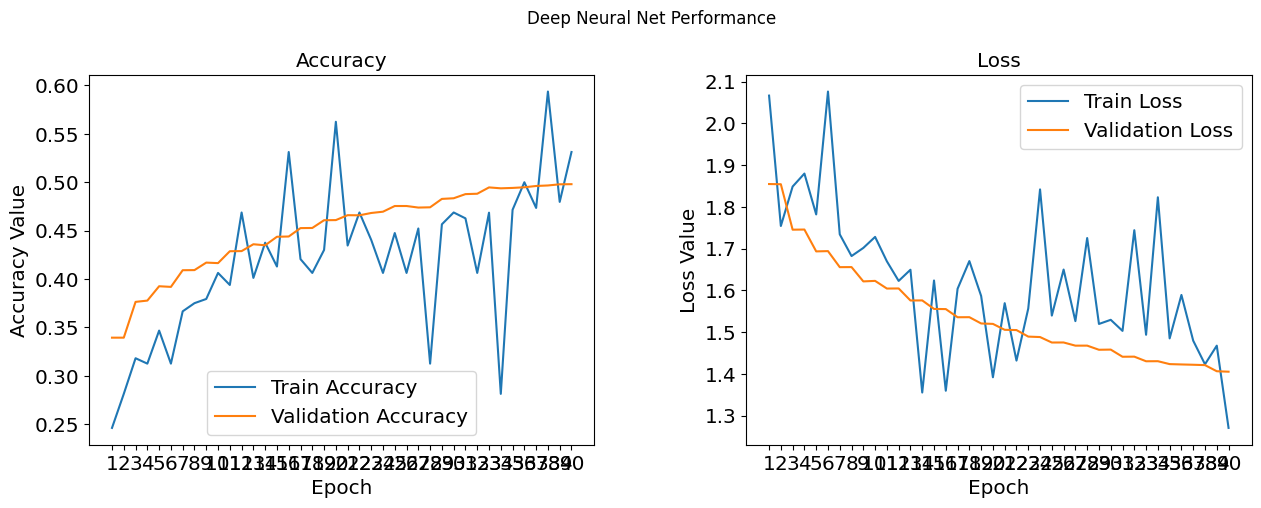

In [68]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history_2.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history_2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history_2.history['loss'], label='Train Loss')
ax2.plot(epochs, history_2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [69]:
predictions_2 = model_2.predict(X_test/255.)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


In [70]:
test_labels = list(y_test.squeeze())
predictions_2 = list(predictions_2.argmax(axis=1))

In [71]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions_2)

Accuracy: 0.5008
Precision: 0.4928
Recall: 0.5008
F1 Score: 0.495


In [72]:
error_metrics_report_2 = classification_report(y_test, predictions_2)
print(error_metrics_report_2)

              precision    recall  f1-score   support

           0       0.52      0.55      0.54      1000
           1       0.58      0.61      0.59      1000
           2       0.38      0.35      0.36      1000
           3       0.36      0.24      0.29      1000
           4       0.44      0.41      0.42      1000
           5       0.42      0.43      0.42      1000
           6       0.51      0.59      0.55      1000
           7       0.54      0.58      0.56      1000
           8       0.62      0.68      0.65      1000
           9       0.56      0.57      0.57      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.49      0.50      0.50     10000



In [82]:
Accuracy.append(accuracy_score(y_test, predictions_2))
Precision.append(precision_score(y_test, predictions_2, average = 'macro'))
Recall.append(recall_score(y_test, predictions_2, average = 'macro'))
F1_Score.append(f1_score(y_test, predictions_2, average = 'macro'))
print(Accuracy, '\n', Precision, '\n', Recall, '\n', F1_Score)


[0.655, 0.5008] 
 [0.6551154152560221, 0.4927624651845129] 
 [0.655, 0.5007999999999999] 
 [0.6539501197331854, 0.4950009603150436]


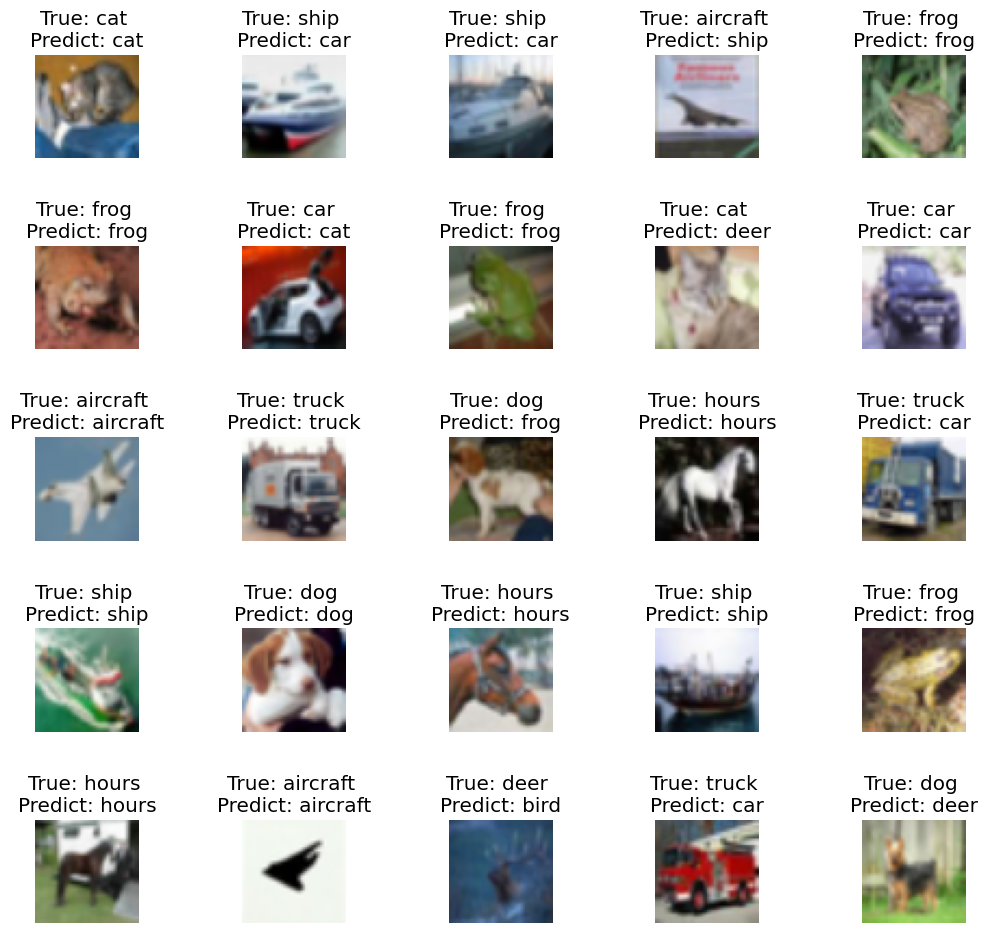

In [74]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (classes[np.argmax(Y_test[i])],
                                                  classes[predictions_2[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


In [75]:
# Run this cell once!

ErrorMetrics.append(Accuracy)
ErrorMetrics.append(Precision)
ErrorMetrics.append(Recall)
ErrorMetrics.append(F1_Score)

In [76]:
ErrorMetrics

[[0.655, 0.5008],
 [0.6551154152560221, 0.4927624651845129],
 [0.655, 0.5007999999999999],
 [0.6539501197331854, 0.4950009603150436]]

In [77]:
ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd

,0,1
0,0.655000,0.500800
1,0.655115,0.492762
2,0.655000,0.500800
3,0.653950,0.495001


In [78]:
ErrorMetrics_pd.columns = PretrainedModels
ErrorMetrics_pd

,VGG-16,VGG_19
0,0.655000,0.500800
1,0.655115,0.492762
2,0.655000,0.500800
3,0.653950,0.495001


In [79]:
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd

,0,1,2,3
VGG-16,0.6550,0.655115,0.6550,0.653950
VGG_19,0.5008,0.492762,0.5008,0.495001


In [80]:
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

,Accuracy,Precision,Recall,F1_Score
VGG-16,0.6550,0.655115,0.6550,0.653950
VGG_19,0.5008,0.492762,0.5008,0.495001


<Axes: >

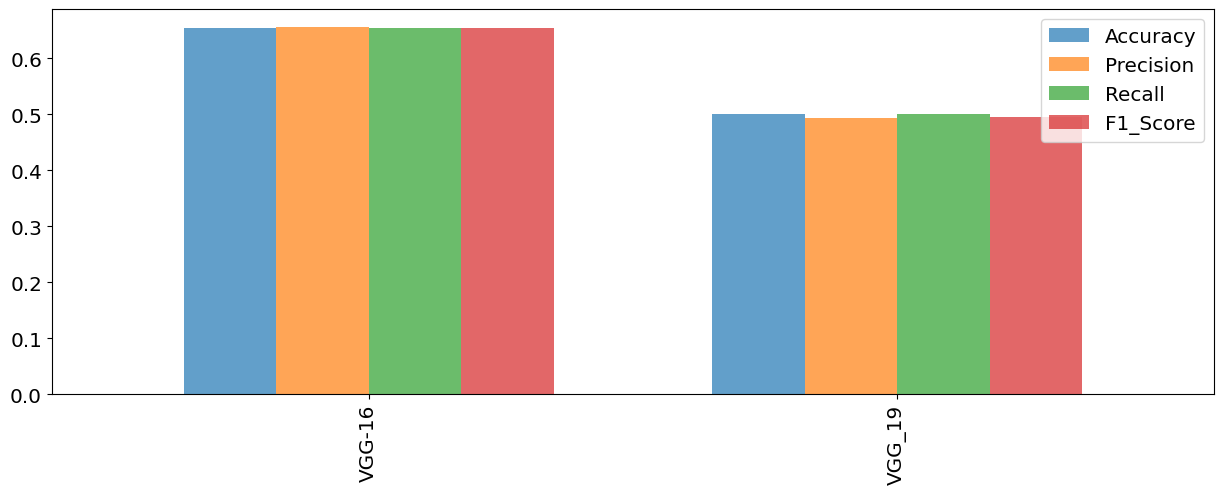

In [81]:
# Here you should get the performance comparing histogram of 2 modified pre-trained modes: VGG16 and VGG19

ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)